In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation

In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  22477
Storage of Prey Expert Buffer:  200000 



[PREDATOR] Epoch 01 | Train Loss: 0.473421 | Val Loss: 0.307592
[PREDATOR] Epoch 02 | Train Loss: 0.359443 | Val Loss: 0.434947
[PREDATOR] Epoch 03 | Train Loss: 0.454497 | Val Loss: 0.298531
[PREDATOR] Epoch 04 | Train Loss: 0.289854 | Val Loss: 0.243698
[PREDATOR] Epoch 05 | Train Loss: 0.439083 | Val Loss: 0.378177
[PREDATOR] Epoch 06 | Train Loss: 0.412051 | Val Loss: 0.315990
[PREDATOR] Epoch 07 | Train Loss: 0.409217 | Val Loss: 0.357830
[PREDATOR] Epoch 08 | Train Loss: 0.330434 | Val Loss: 0.274066
[PREDATOR] Epoch 09 | Train Loss: 0.376509 | Val Loss: 0.338639
[PREDATOR] Epoch 10 | Train Loss: 0.360409 | Val Loss: 0.228614
[PREDATOR] Epoch 11 | Train Loss: 0.347021 | Val Loss: 0.254634
[PREDATOR] Epoch 12 | Train Loss: 0.359160 | Val Loss: 0.241199
[PREDATOR] Epoch 13 | Train Loss: 0.342002 | Val Loss: 0.439862
[PREDATOR] Epoch 14 | Train Loss: 0.368195 | Val Loss: 0.463687
[PREDATOR] Epoch 15 | Train Loss: 0.526054 | Val Loss: 0.182641
[PREDATOR] Epoch 16 | Train Loss: 0.3584

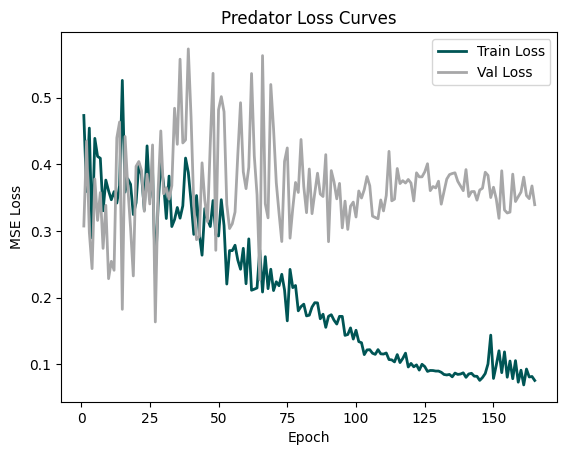

In [5]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 1.339126 | Val Loss: 1.371261 | Pred Gain: 0.499750018119812
[PREY] Epoch 02 | Train Loss: 1.299838 | Val Loss: 1.207060 | Pred Gain: 0.49950018525123596
[PREY] Epoch 03 | Train Loss: 1.281421 | Val Loss: 1.244092 | Pred Gain: 0.49925047159194946
[PREY] Epoch 04 | Train Loss: 1.359744 | Val Loss: 1.331413 | Pred Gain: 0.49900051951408386
[PREY] Epoch 05 | Train Loss: 1.307050 | Val Loss: 1.250206 | Pred Gain: 0.4987505376338959
[PREY] Epoch 06 | Train Loss: 1.323662 | Val Loss: 1.436111 | Pred Gain: 0.498500257730484
[PREY] Epoch 07 | Train Loss: 1.307964 | Val Loss: 1.326983 | Pred Gain: 0.498249888420105
[PREY] Epoch 08 | Train Loss: 1.335539 | Val Loss: 1.253790 | Pred Gain: 0.49799925088882446
[PREY] Epoch 09 | Train Loss: 1.299173 | Val Loss: 1.309207 | Pred Gain: 0.4977489113807678
[PREY] Epoch 10 | Train Loss: 1.314839 | Val Loss: 1.304188 | Pred Gain: 0.4974985718727112
[PREY] Epoch 11 | Train Loss: 1.380203 | Val Loss: 1.371449 | Pred Gain: 0.4972

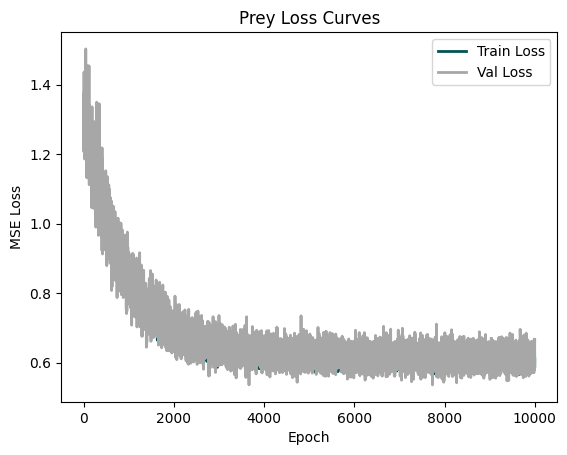

In [6]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=10000, lr=1e-3, early_stopping=True, patience=50)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

In [8]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.


ValueError: not enough values to unpack (expected 9, got 8)